In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path = '/kaggle/input/mushrooms-classification-common-genuss-images/mushrooms/Mushrooms/'
df = pd.DataFrame()
for imlabel in os.listdir(path):
    for image in os.listdir(path+imlabel):
        df = df.append({"path" : path+imlabel+"/"+image, "label" : imlabel}, ignore_index=True)

df.head()

,path,label
0,/kaggle/input/mushrooms-classification-common-...,Entoloma
1,/kaggle/input/mushrooms-classification-common-...,Entoloma
2,/kaggle/input/mushrooms-classification-common-...,Entoloma
3,/kaggle/input/mushrooms-classification-common-...,Entoloma
4,/kaggle/input/mushrooms-classification-common-...,Entoloma


## Splitting Data :
70%, 20%, 10% for training, validation and testing respecitvely

In [3]:
train_X, val_test_X, train_Y, val_test_Y = train_test_split(df['path'], df['label'], test_size=0.3, shuffle=True)
train_data = pd.concat({'path':train_X, 'label':train_Y}, axis=1)

val_X, test_X, val_Y, test_Y = train_test_split(val_test_X, val_test_Y, test_size=0.33, shuffle=True)

validation_data = pd.concat({'path':val_X, 'label':val_Y}, axis=1)
test_data = pd.concat({'path':test_X, 'label':test_Y}, axis=1)

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
vertical_flip = True)
train_data_generator = train_datagen.flow_from_dataframe(train_data,
                                                         x_col = 'path',
                                                         y_col = 'label',
                                                        batch_size=32,
                                                         color_mode="rgb",
                                                         target_size=(224, 224),
                                                        class_mode="categorical")
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data_generator = validation_datagen.flow_from_dataframe(validation_data,
                                                                   x_col = 'path',
                                                                   y_col = 'label',
                                                                   batch_size=32,
                                                                   color_mode="rgb",
                                                                   target_size=(224, 224),
                                                                   class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_dataframe(test_data,
                                         x_col = 'path',
                                          y_col = 'label',
                                          batch_size=test_data['path'].shape[0],
                                          color_mode="rgb",
                                          target_size=(224, 224),
                                          class_mode="categorical")

Found 4699 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 665 validated image filenames belonging to 9 classes.


In [49]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint ,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report


In [6]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

2022-01-16 17:17:48.871599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 17:17:48.885459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 17:17:48.886415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-16 17:17:48.888307: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
model = Sequential()
model.add(densenet)
model.add(tensorflow.keras.layers.GlobalAveragePooling2D())
model.add(tensorflow.keras.layers.Dense(9, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 9225      
Total params: 7,046,729
Trainable params: 6,963,081
Non-trainable params: 83,648
_________________________________________________________________


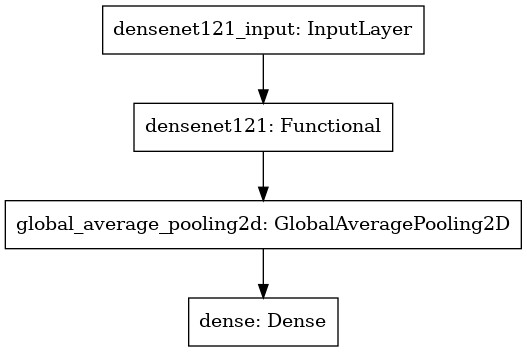

In [9]:
tensorflow.keras.utils.plot_model(model)

In [10]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

early = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.09,patience=2)

history = model.fit(train_data_generator, epochs=2, validation_data=validation_data_generator, callbacks=[early, reduce_lr])

2022-01-16 17:18:09.747339: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-01-16 17:18:20.618051: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


147/147 [==============================] - 118s 717ms/step - loss: 1.3675 - accuracy: 0.5397 - f1_m: 0.4965 - precision_m: 0.6788 - recall_m: 0.3969 - val_loss: 4.9958 - val_accuracy: 0.2526 - val_f1_m: 0.2529 - val_precision_m: 0.2645 - val_recall_m: 0.2425
Epoch 2/2
147/147 [==============================] - 103s 699ms/step - loss: 0.9419 - accuracy: 0.6838 - f1_m: 0.6700 - precision_m: 0.7801 - recall_m: 0.5903 - val_loss: 2.4151 - val_accuracy: 0.5481 - val_f1_m: 0.5519 - val_precision_m: 0.5791 - val_recall_m: 0.5279


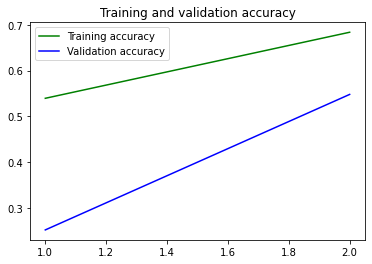

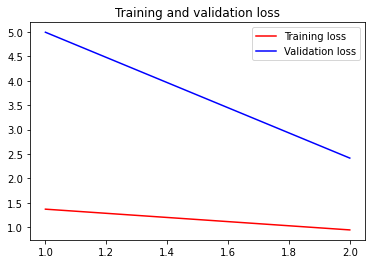

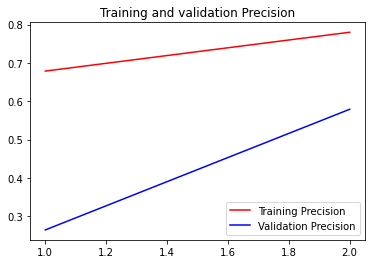

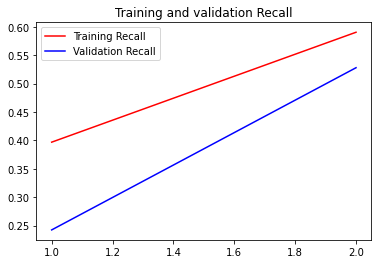

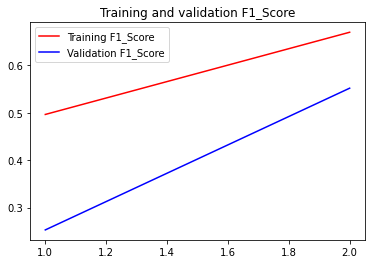

In [11]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
f1_score = history.history['f1_m']
val_f1_score = history.history['val_f1_m']

import matplotlib.pyplot as plt

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, f1_score, 'r', label='Training F1_Score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1_Score')
plt.title('Training and validation F1_Score')
plt.legend()
plt.show()

In [12]:
model_evaluate = model.evaluate(test_data_generator)

1/1 [==============================] - 11s 11s/step - loss: 2.6008 - accuracy: 0.5158 - f1_m: 0.5191 - precision_m: 0.5388 - recall_m: 0.5008


In [13]:
print(f"Test Accuracy   :  {model_evaluate[1]}")
print(f"Test Loss       :  {model_evaluate[0]}")
print(f"Test Precission :  {model_evaluate[3]}")
print(f"Test Recall     :  {model_evaluate[4]}")
print(f"Test F1 Score   :  {model_evaluate[2]}")

Test Accuracy   :  0.5157894492149353
Test Loss       :  2.600788116455078
Test Precission :  0.5388349294662476
Test Recall     :  0.5007518529891968
Test F1 Score   :  0.519095778465271


In [14]:
for image, lab in test_data_generator:
    break;

predict_y = model.predict(image)

## Confusion Matrix heatmap

[Text(0.5, 15.0, 'true_value'), Text(33.0, 0.5, 'prediction')]

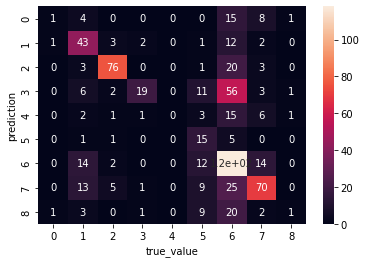

In [48]:
import seaborn as sns

cnf = tensorflow.math.confusion_matrix(np.argmax(lab, axis=1), np.argmax(predict_y, axis=1))
c_plot = sns.heatmap(cnf, annot=True)
c_plot.set(xlabel='true_value', ylabel='prediction')

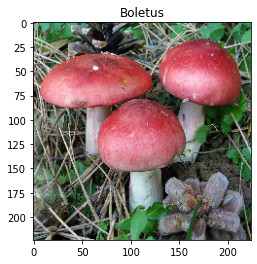

True prediction


In [43]:
def show_predicted_image(i):
    plt.imshow(image[i])
    plt.title(os.listdir(path)[np.argmax(predict_y[i])])
    plt.show()
    if (np.argmax(predict_y[i])==np.argmax(lab[i])):
        print("True prediction")
    else:
        print("Wrong value prediction")
        print(f"Correct label is : {os.listdir(path)[np.argmax(lab[i])]}")
        
show_predicted_image(4)

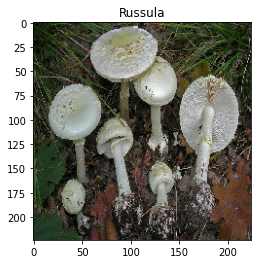

Wrong value prediction
Correct label is : Suillus


In [44]:
show_predicted_image(7)

## Test data Classification Report : 

## Classification report for test datset

In [54]:
print(classification_report(np.argmax(lab, axis=1), np.argmax(predict_y, axis=1)))

              precision    recall  f1-score   support

           0       0.33      0.03      0.06        29
           1       0.48      0.67      0.56        64
           2       0.84      0.74      0.79       103
           3       0.79      0.19      0.31        98
           4       0.00      0.00      0.00        29
           5       0.25      0.68      0.36        22
           6       0.41      0.74      0.53       160
           7       0.65      0.57      0.61       123
           8       0.25      0.03      0.05        37

    accuracy                           0.52       665
   macro avg       0.45      0.41      0.36       665
weighted avg       0.55      0.52      0.48       665

